### Import Library

In [ ]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import string
import re
import nltk
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import pickle
import requests
import json
import csv
from sklearn.svm import SVC
from io import StringIO

In [66]:
nltk.download('punkt', force=True)
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ejaad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejaad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocessing data

In [67]:
# Load data ulasan
data = pd.read_csv("magic_chess_reviews.csv")

In [68]:
# Cek data frame
df = pd.DataFrame(data)
df.shape
df.head()

,userName,score,content
0,Pengguna Google,5,"Gem nya lumayan keren si , semoga tahun depan ..."
1,Pengguna Google,3,Kurang mc itu sekarang hampir semua hero tdk a...
2,Pengguna Google,1,Kurang bagus ton jelek
3,Pengguna Google,3,Paling males kalo ketemu lawan yang pake combo...
4,Pengguna Google,5,Game. Nya bagus


In [69]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df.shape

In [70]:
# Hapus missing value
clean_df = df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

### Preprocessing teks

In [71]:
# Inisialisasi stemmer bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [72]:
# ============ Membaca Stopwords dari GitHub ============
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-id/master/stopwords-id.txt"
response = requests.get(stopwords_url)
if response.status_code == 200:
    stop_words = set(response.text.split("\n"))
else:
    print("Failed to fetch stopwords")
    stop_words = set()

In [73]:
# ============ Membaca Daftar Kata Sentimen dari GitHub ============
# Membaca kata-kata positif
lexicon_positive = set()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive.add(row[0])  # Simpan hanya kata, tanpa skor
else:
    print("Failed to fetch positive lexicon data")

In [74]:
# ============ Membaca Daftar Kata Sentimen dari GitHub ============
# Membaca kata-kata negatif
lexicon_negative = set()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative.add(row[0])  # Simpan hanya kata, tanpa skor
else:
    print("Failed to fetch negative lexicon data")

In [75]:
# ============ Fungsi Preprocessing ============
def preprocess_text(text):
    """Membersihkan teks dari karakter khusus, stopwords, dan melakukan tokenisasi"""
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Lowercasing
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Menghapus RT
    text = re.sub(r'http\S+', '', text)  # Menghapus URL/link
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus karakter selain huruf dan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = text.strip()  # Menghapus spasi di awal dan akhir

    tokens = re.findall(r'\b\w+\b', text)  # Tokenisasi dengan regex
    tokens = [word for word in tokens if word not in stop_words]  # Stopword removal
    return " ".join(tokens)

In [76]:
# ============ Fungsi Labeling Sentimen ============
def label_sentiment(text):
    """Menentukan sentimen berdasarkan jumlah kata positif dan negatif"""
    words = set(text.split())  # Konversi teks ke set kata unik
    pos_count = len(words & lexicon_positive)  # Hitung jumlah kata positif
    neg_count = len(words & lexicon_negative)  # Hitung jumlah kata negatif

    if pos_count > neg_count:
        return 1  # Positif
    elif neg_count > pos_count:
        return -1  # Negatif
    else:
        return 0  # Netral

In [77]:
if 'content' in df.columns:
    df['clean_content'] = df['content'].apply(preprocess_text)
    df['sentiment'] = df['clean_content'].apply(label_sentiment)

    # Simpan hasil preprocessing dan labeling
    processed_filename = "magic_chess_reviews_clean.csv"
    df[['clean_content', 'sentiment']].to_csv(processed_filename, index=False)
    print(f"Preprocessing dan labeling selesai. Data disimpan dalam {processed_filename}")
else:
    print("Kolom 'content' tidak ditemukan dalam data.")

# Cek hasil
print(df)

Preprocessing dan labeling selesai. Data disimpan dalam magic_chess_reviews_clean.csv
              userName  score  \
0      Pengguna Google      5   
1      Pengguna Google      3   
2      Pengguna Google      1   
3      Pengguna Google      3   
4      Pengguna Google      5   
...                ...    ...   
29995  Pengguna Google      5   
29996  Pengguna Google      1   
29997  Pengguna Google      1   
29998  Pengguna Google      1   
29999  Pengguna Google      1   

                                                 content  \
0      Gem nya lumayan keren si , semoga tahun depan ...   
1      Kurang mc itu sekarang hampir semua hero tdk a...   
2                                 Kurang bagus ton jelek   
3      Paling males kalo ketemu lawan yang pake combo...   
4                                        Game. Nya bagus   
...                                                  ...   
29995                               game nya seru banget   
29996  Salah atuh bos pisah dari mobi

## Analisis sentimen

C:\Users\ejaad\AppData\Local\Temp\ipykernel_3372\3581007145.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'].map({-1: "Negatif", 0: "Netral", 1: "Positif"}), palette='coolwarm')


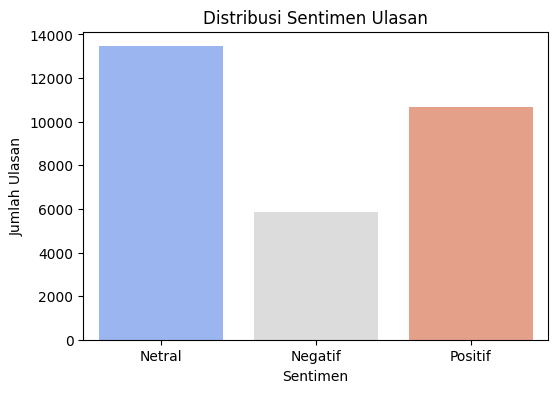

In [78]:
# Analisis Sentimen
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentiment'].map({-1: "Negatif", 0: "Netral", 1: "Positif"}), palette='coolwarm')
plt.title("Distribusi Sentimen Ulasan")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.show()

C:\Users\ejaad\AppData\Local\Temp\ipykernel_3372\262717458.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


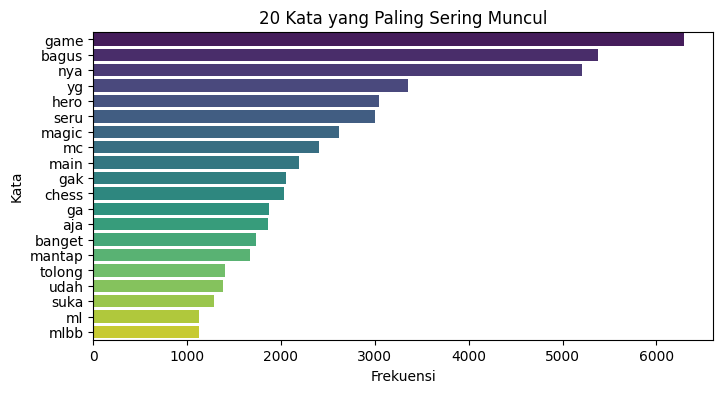

In [79]:

# Analisis Kata Kunci
all_words = " ".join(df['clean_content']).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title("20 Kata yang Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

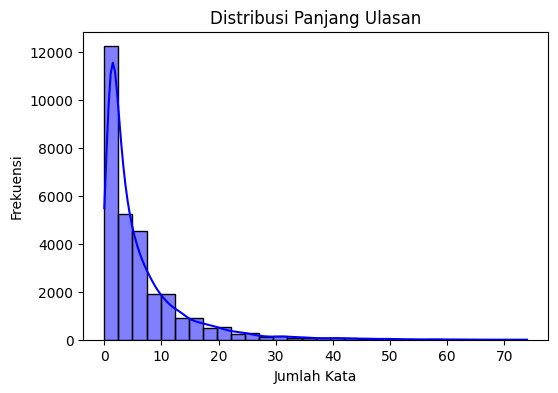

In [80]:
# Distribusi Panjang Teks
df['text_length'] = df['clean_content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title("Distribusi Panjang Ulasan")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()


C:\Users\ejaad\AppData\Local\Temp\ipykernel_3372\1723424477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['score'], y=df['sentiment'], palette='coolwarm')


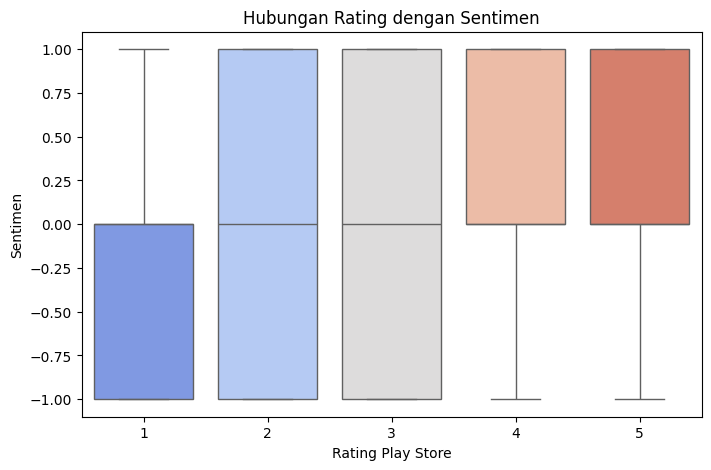

In [81]:
# Analisis Rating vs Sentimen
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['score'], y=df['sentiment'], palette='coolwarm')
plt.title("Hubungan Rating dengan Sentimen")
plt.xlabel("Rating Play Store")
plt.ylabel("Sentimen")
plt.show()

## Modeling menggunakan LSTM

In [82]:
# Memuat data hasil preprocessing
df = pd.read_csv("magic_chess_reviews_clean.csv")

# Pilih teks dan label sentimen
X_text = df['clean_content']
y = df['sentiment']

# Hapus baris yang memiliki NaN pada teks
df = df.dropna(subset=['clean_content'])

# Atau, ganti NaN dengan string kosong
df['clean_content'] = df['clean_content'].fillna("")


In [83]:
X_text = df['clean_content'].astype(str)

print("Jumlah data kosong sebelum pemrosesan:", df['clean_content'].isna().sum())
print(df.head())  # Untuk melihat apakah ada data aneh

Jumlah data kosong sebelum pemrosesan: 0
                                       clean_content  sentiment
0      gem nya lumayan keren si semoga gem nya keren          0
1  mc hero tdk skin mc ml hero mc skin skin colek...          0
2                                    bagus ton jelek         -1
3  males kalo ketemu lawan pake combo sinergi pak...          0
4                                     game nya bagus          1


In [84]:
X_text = df['clean_content'].astype(str).tolist()
y = df['sentiment'].values  


In [85]:
print("Jumlah data kosong setelah konversi:", sum(pd.Series(X_text).isna()))
print("Contoh data:", X_text[:5])


Jumlah data kosong setelah konversi: 0
Contoh data: ['gem nya lumayan keren si semoga gem nya keren', 'mc hero tdk skin mc ml hero mc skin skin colektor zodiak enda dihilangin mcgogo kurangnya effect grafik memukau ml', 'bagus ton jelek', 'males kalo ketemu lawan pake combo sinergi pake kalo orang mah gapapa orang hero stok nya rolling gak dapetdapet itupun pake hero sinyal suka tibatiba jelek pas main sekian terima kasih', 'game nya bagus']


In [86]:
# ==================== TF-IDF + SVM (80/20) ====================
print("\nModel: SVM + TF-IDF (80/20)")
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Membagi data latih dan data uji (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Melatih model SVM
svm_model = SVC(kernel='linear', C=2, degree = 3, gamma = 0.1)
svm_model.fit(X_train, y_train)

y_train_svm = svm_model.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_svm))

# Evaluasi model
y_pred_svm = svm_model.predict(X_test)

print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))




Model: SVM + TF-IDF (80/20)
Akurasi Pelatihan: 0.9792010844241115
Akurasi Pengujian: 0.9235852253473399
              precision    recall  f1-score   support

          -1       0.91      0.86      0.88      1139
           0       0.90      0.94      0.92      2628
           1       0.96      0.94      0.95      2135

    accuracy                           0.92      5902
   macro avg       0.92      0.91      0.92      5902
weighted avg       0.92      0.92      0.92      5902



In [87]:
# ==================== Word2Vec + RF (80/20) ====================
print("\nModel: RF + Word2Vec (80/20)")
tokenized_text = [text.split() for text in X_text]
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = w2v_model.wv

def text_to_w2v(text):
    words = text.split()
    words = [word for word in words if word in word_vectors]
    if len(words) == 0:
        return np.zeros(100)
    return np.mean([word_vectors[word] for word in words], axis=0)

X_w2v = np.array([text_to_w2v(text) for text in X_text])

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_train_rf_w2v = rf_model.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_rf_w2v))

y_pred_rf_w2v = rf_model.predict(X_test)
print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_rf_w2v))
print(classification_report(y_test, y_pred_rf_w2v))


Model: RF + Word2Vec (80/20)
Akurasi Pelatihan: 0.9995763968314483
Akurasi Pengujian: 0.7016265672653338
              precision    recall  f1-score   support

          -1       0.51      0.54      0.53      1139
           0       0.74      0.75      0.74      2628
           1       0.77      0.72      0.75      2135

    accuracy                           0.70      5902
   macro avg       0.67      0.67      0.67      5902
weighted avg       0.71      0.70      0.70      5902



In [88]:
# ==================== TF-IDF + RF (70/30) ====================
print("\nModel: RF + TF-IDF (70/30)")
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

rf_model_tfidf = RandomForestClassifier(n_estimators=100, min_samples_split=5,random_state=42)
rf_model_tfidf.fit(X_train, y_train)

y_train_rf_tfidf = rf_model_tfidf.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_rf_tfidf))

y_pred_rf_tfidf = rf_model_tfidf.predict(X_test)
print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_rf_tfidf))
print(classification_report(y_test, y_pred_rf_tfidf))


Model: RF + TF-IDF (70/30)
Akurasi Pelatihan: 0.9990317583268784
Akurasi Pengujian: 0.8545125946007003
              precision    recall  f1-score   support

          -1       0.78      0.79      0.78      1708
           0       0.86      0.84      0.85      3915
           1       0.89      0.90      0.89      3230

    accuracy                           0.85      8853
   macro avg       0.84      0.85      0.84      8853
weighted avg       0.85      0.85      0.85      8853



# Inference model

In [89]:
# Simpan Model Random Forest
with open("rf_model_tfidf.pkl", "wb") as model_file:
    pickle.dump(rf_model_tfidf, model_file)

# simpan model svm
with open("svm_model_tfidf.pkl", "wb") as model_file:
    pickle.dump(svm_model, model_file)

# Simpan TF-IDF Vectorizer setelah training
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf_vectorizer, file)

print("Model dan vectorizer berhasil disimpan!")


Model dan vectorizer berhasil disimpan!


In [90]:
# ====== Load Model & TF-IDF Vectorizer ======
with open("rf_model_tfidf.pkl", "rb") as model_file:
    rf_model_tfidf = pickle.load(model_file)
    
# ====== Load Model & TF-IDF Vectorizer ======
with open("svm_model_tfidf.pkl", "rb") as model_file:
    svm_model_tfidf = pickle.load(model_file)

# Load kembali TF-IDF Vectorizer dari file
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)


In [91]:
review_tfidf = tfidf_vectorizer.transform(["Game ini seru!"])
print(f"Jumlah fitur saat inference: {review_tfidf.shape[1]}")  # Harus sama dengan training
print(f"Jumlah fitur yang diharapkan oleh RF: {rf_model_tfidf.n_features_in_}")
print(f"Jumlah fitur yang diharapkan oleh RF: {svm_model_tfidf.n_features_in_}")

Jumlah fitur saat inference: 10000
Jumlah fitur yang diharapkan oleh RF: 10000
Jumlah fitur yang diharapkan oleh RF: 10000


In [92]:
# ====== Load Stopwords & Stemmer ======
# URL stopwords dari GitHub
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-id/master/stopwords-id.json"

# Mengambil data stopwords dari GitHub
response = requests.get(url)
stopwords_indonesia = set(json.loads(response.text))

# ====== Preprocessing Function ======
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove links
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords_indonesia])  # Stemming & Stopwords
    return text

# ====== Mapping Sentimen ======
sentiment_mapping = {-1: "Negatif", 0: "Netral", 1: "Positif"}




In [94]:
#  ====== Inference Function SVM Model ======
def predict_sentiment(review):
    # Preprocessing teks
    clean_review = preprocess_text(review)

    # Gunakan TF-IDF Vectorizer yang sudah dipakai saat training
    review_tfidf = tfidf_vectorizer.transform([clean_review])

    # Prediksi menggunakan model yang sudah dilatih
    sentiment_label = svm_model_tfidf.predict(review_tfidf)[0]

    return sentiment_mapping[sentiment_label]


# ====== Contoh Testing ======
if __name__ == "__main__":
    test_reviews = [
        "Game ini sangat menyenangkan dan seru!",
        "Grafik bagus tapi banyak bug yang mengganggu.",
        "Lumayanlah, gak terlalu buruk.",
        "kurang baik",
        "jujur ini buruk",
        "lumayanlah"
    ]

    for review in test_reviews:
        print(f"Review: {review} -> Sentimen: {predict_sentiment(review)}")

Review: Game ini sangat menyenangkan dan seru! -> Sentimen: Positif
Review: Grafik bagus tapi banyak bug yang mengganggu. -> Sentimen: Negatif
Review: Lumayanlah, gak terlalu buruk. -> Sentimen: Negatif
Review: kurang baik -> Sentimen: Netral
Review: jujur ini buruk -> Sentimen: Negatif
Review: lumayanlah -> Sentimen: Netral
